# Assignment 1: Acoustic Activity Recognition

In this assignment, you will build a machine learning system for acoustic activity recognition using your smartphone microphone. You will collect a custom audio dataset, extract various features, train multiple classification models, and evaluate their performance across different conditions. Each section below corresponds to a part of the assignment, with clear instructions and placeholders where you need to implement your solutions.

## Setup and Configuration

This section imports necessary libraries and mounts Google Drive for file access. We'll use libraries for audio processing (librosa), machine learning (scikit-learn), visualization (matplotlib, seaborn) and various utility functions.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import hashlib
import random
from tqdm.notebook import tqdm
from sklearn.base import clone

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Error mounting Google Drive. Please run this cell again.")

Error mounting Google Drive. Please run this cell again.


## Dataset Configuration

Each student will have a unique dataset ID based on their name. This ID will be used to create a folder for storing your audio recordings. The configuration also defines the activities, environments, and other parameters for the assignment.

In [17]:
# Create a unique dataset ID based on student name
def generate_dataset_id(name):
    """
    Generate a 5-digit random number based on the hash of the name.
    Use this as your dataset folder name.
    """
    hash_object = hashlib.md5(name.encode())
    hex_dig = hash_object.hexdigest()
    seed = int(hex_dig, 16) % (10**8)
    random.seed(seed)
    return random.randint(10000, 99999)

# Enter your name to generate your dataset ID
student_name = "Sharwin Patil"
dataset_id = generate_dataset_id(student_name)
print(f"Your dataset folder ID is: {dataset_id}")
print(f"Please name your dataset folder: {dataset_id}")
os.makedirs(f"{dataset_id}", exist_ok=True)
# Configuration
ACTIVITIES = ['laugh', 'cough', 'clap', 'knock', 'alarm']
ENVIRONMENTS = ['small', 'large']
NUM_INSTANCES = 10
SAMPLE_RATE = 16000  # Standard sample rate for audio
WINDOW_SIZES = [1, 5, 'full']  # in seconds - 3 required window sizes

Your dataset folder ID is: 21524
Please name your dataset folder: 21524


Note: all of the input audio files should be resampled to 16kHz for analysis.

In [18]:
# Sample function to resample the input audio to 16kHz
def load_audio_16k(path):
    audio, sr = librosa.load(path, SAMPLE_RATE=16000)  # Resample to 16 kHz
    return audio, sr

# A1.1: Data Collection (4 points)

n this section, we will validate your dataset to ensure it meets the requirements. You should have recorded 5 activities (laugh, cough, clap, knock, alarm), with 10 recordings each in 2 different environments (e.g., a small room and a large room).

This results in a total of 100 audio recordings (5 activities × 10 instances × 2 environments).

Each recording should be about 20 seconds long and named using the format activity_environment_instanceNumber.wav.

For example, cough_small_3.wav would represent the 4th coughing sample recorded in a small room.

## Dataset Management Functions

These functions help with listing, validating, and visualizing your audio files. The naming convention for your files should be: `activity_environment_instanceNumber.wav`

In [19]:
def list_audio_files(base_path):
    """
    List all audio files in the dataset directory.

    Args:
        base_path: Path to the dataset directory

    Returns:
        List of audio file paths
    """
    audio_files = []

    # Find all WAV files in the dataset directory
    if os.path.exists(base_path):
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.endswith('.wav'):
                    # Check if the file follows the naming convention
                    parts = os.path.splitext(file)[0].split('_')
                    if len(parts) == 3:
                        activity, environment, instance = parts
                        # Validate activity and environment
                        if activity in ACTIVITIES and environment in ENVIRONMENTS:
                            # Try to convert instance to int
                            try:
                                instance_num = int(instance)
                                if 0 <= instance_num < NUM_INSTANCES:
                                    audio_files.append(os.path.join(root, file))
                            except ValueError:
                                pass

    return audio_files

def validate_dataset(audio_files):
    """
    Validate that the dataset contains the required number and types of files.

    Args:
        audio_files: List of audio file paths

    Returns:
        dict: Statistics of the dataset
        bool: True if the dataset meets requirements
    """
    stats = {
        'total_files': 0,
        'files_by_activity': {activity: 0 for activity in ACTIVITIES},
        'files_by_environment': {env: 0 for env in ENVIRONMENTS},
        'activity_env_matrix': {
            f"{activity}_{env}": 0
            for activity in ACTIVITIES
            for env in ENVIRONMENTS
        },
        'valid': False
    }

    # Count files by activity and environment
    for file_path in audio_files:
        file_name = os.path.basename(file_path)
        parts = os.path.splitext(file_name)[0].split('_')

        if len(parts) == 3:
            activity, environment, _ = parts

            if activity in ACTIVITIES and environment in ENVIRONMENTS:
                stats['total_files'] += 1
                stats['files_by_activity'][activity] += 1
                stats['files_by_environment'][environment] += 1
                stats['activity_env_matrix'][f"{activity}_{environment}"] += 1

    # Check if all required files are present
    required_count = 0
    for activity in ACTIVITIES:
        for env in ENVIRONMENTS:
            key = f"{activity}_{env}"
            # Should have NUM_INSTANCES instances for each activity-environment pair
            if stats['activity_env_matrix'][key] == NUM_INSTANCES:
                required_count += 1

    # Set valid flag
    stats['valid'] = (required_count == len(ACTIVITIES) * len(ENVIRONMENTS))

    return stats

In [20]:
def display_dataset_stats(stats):
    """
    Display statistics about the dataset.

    Args:
        stats: Dictionary of dataset statistics
    """
    print(f"Total files: {stats['total_files']}")
    print("\nFiles by activity:")
    for activity, count in stats['files_by_activity'].items():
        print(f"  {activity}: {count}")

    print("\nFiles by environment:")
    for env, count in stats['files_by_environment'].items():
        print(f"  {env}: {count}")

    print("\nActivity-Environment Matrix:")
    # Create a matrix for visualization
    matrix_data = np.zeros((len(ACTIVITIES), len(ENVIRONMENTS)))
    for i, activity in enumerate(ACTIVITIES):
        for j, env in enumerate(ENVIRONMENTS):
            matrix_data[i, j] = stats['activity_env_matrix'][f"{activity}_{env}"]

    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix_data, annot=True, fmt='g', cmap='viridis',
                xticklabels=ENVIRONMENTS, yticklabels=ACTIVITIES)
    plt.title('Number of recordings per activity and environment')
    plt.ylabel('Activity')
    plt.xlabel('Environment')
    plt.tight_layout()
    plt.show()

    if stats['valid']:
        print("\n✅ Dataset meets the requirements!")
    else:
        print("\n❌ Dataset does not meet requirements. Please check your files.")

def plot_audio_waveform(audio_path):
    """
    Plot the waveform of an audio file.

    Args:
        audio_path: Path to the audio file
    """
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Create the plot
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {os.path.basename(audio_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

    # Display audio player
    display(ipd.Audio(y, rate=sr))

Now that we have the dataset management functions, let's use them to verify your dataset. The code below will list the files in your dataset folder, compute dataset statistics, and display a summary. It will also randomly select a few audio files and display their waveforms as a quick inspection of your recordings.

Checking dataset...
Total files: 50

Files by activity:
  laugh: 10
  cough: 10
  clap: 10
  knock: 10
  alarm: 10

Files by environment:
  small: 0
  large: 50

Activity-Environment Matrix:


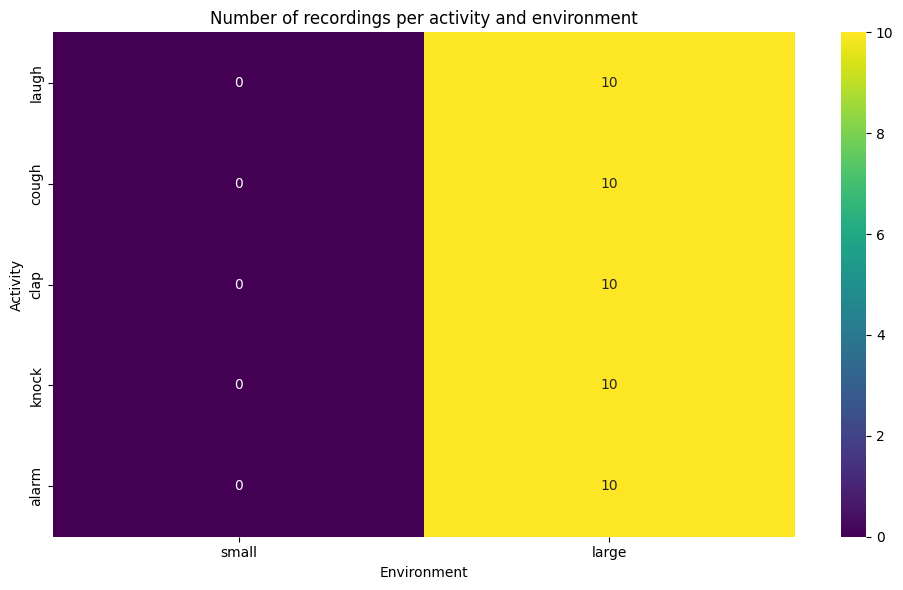


❌ Dataset does not meet requirements. Please check your files.


False

In [21]:
def test_data_collection(dataset_path=f"/content/drive/MyDrive/CSXXX/{dataset_id}"):
    """
    Test function for data collection section.
    """
    print("Checking dataset...")
    audio_files = list_audio_files(dataset_path)
    stats = validate_dataset(audio_files)
    display_dataset_stats(stats)

    if stats['valid'] and len(audio_files) > 0:
        # Display a sample of audio files
        print("\nDisplaying a sample of audio files:")
        sample_files = random.sample(audio_files, min(3, len(audio_files)))
        for file in sample_files:
            print(f"\nAudio file: {os.path.basename(file)}")
            plot_audio_waveform(file)

    return stats['valid']

# Run the test
test_data_collection(dataset_path=f"{dataset_id}")

# A1.2: Feature Extraction (4 points)

In this section, you'll implement three different audio feature extraction techniques:
1. Fast Fourier Transform (FFT) for frequency domain analysis
2. Mel-Frequency Cepstral Coefficients (MFCCs) for spectral features
3. Root Mean Square (RMS) energy for amplitude/energy analysis

We will implement each feature extraction in a separate function. After that, we'll integrate them into a pipeline to apply these features to the entire dataset.

## Feature Extraction Functions

For each feature type, complete the TODOs in the corresponding function. Each function should take an audio signal and return a feature vector (or a set of feature vectors if using windowing).

In [ ]:
def extract_fft(audio_signal, sr=16000):
    """
    Extract Fast Fourier Transform (FFT) features from an audio signal.

    Args:
        audio_signal: The audio signal
        sr: Sample rate

    Returns:
        FFT features
    """
    # TODO: Implement FFT feature extraction
    # Your implementation should:
    # 1. Compute the magnitude spectrum
    # 2. Convert to power spectrum
    # 3. Extract relevant features (e.g., mean, std, energy in frequency bands)
    # 4. Return a one dimensional feature vector

    # Placeholder return
    return np.zeros(9)

def extract_mfcc(audio_signal, sr=16000):
    """
    Extract Mel-Frequency Cepstral Coefficients (MFCCs) from an audio signal.

    Args:
        audio_signal: The audio signal
        sr: Sample rate

    Returns:
        MFCC features
    """
    # TODO: Implement MFCC feature extraction
    # Your implementation should:
    # 1. Extract MFCCs using librosa
    # 2. Calculate statistics for each coefficient
    # 3. Optionally include delta and delta2 features
    # 4. Return a one dimensional feature vector

    # Placeholder return
    return np.zeros(9)

def extract_rms(audio_signal, sr=16000):
    """
    Extract Root Mean Square (RMS) energy features from an audio signal.

    Args:
        audio_signal: The audio signal
        sr: Sample rate

    Returns:
        RMS energy features
    """
    # TODO: Implement RMS feature extraction
    # Your implementation should:
    # 1. Extract RMS energy
    # 2. Calculate statistics (mean, std, max, min)
    # 3. Include additional temporal features if desired
    # 4. Return a one dimensional feature vector

    # Placeholder return
    return np.zeros(9)

## Feature Processing Pipeline

Now we'll integrate the above feature extraction functions into a pipeline that can process a list of audio files and output a feature matrix X, label vector y, and some metadata. This pipeline will also handle windowing: if a window size (in seconds) is provided, it will slice each audio file into windows and treat each window as a separate sample with the same label.

The extract_features function (provided) calls the appropriate extract_* function based on the feature type and also performs windowing if needed. The process_dataset function uses extract_features for each file in the dataset.

In [ ]:
def extract_features(audio_path, feature_type='all'):
    """
    Extract features from an audio file.

    Args:
        audio_path: Path to the audio file
        feature_type: Type of features to extract ('fft', 'mfcc', 'rms', or 'all')

    Returns:
        Extracted features
    """
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Extract features from the whole file
    features = {}
    if feature_type in ['fft', 'all']:
        features['fft'] = extract_fft(y, sr)
    if feature_type in ['mfcc', 'all']:
        features['mfcc'] = extract_mfcc(y, sr)
    if feature_type in ['rms', 'all']:
        features['rms'] = extract_rms(y, sr)

    return features

In [ ]:
def process_dataset(audio_files, feature_types=['fft', 'mfcc', 'rms'], window_size=None):
    """
    Process the entire dataset to extract features and prepare for model training.

    Args:
        audio_files: List of audio file paths
        feature_types: List of feature types to extract
        window_size: Size of the window in seconds (None for whole file)

    Returns:
        X: Feature matrix
        y: Labels
        metadata: Additional information about the data
    """
    # Initialize lists to store features and labels
    X = []
    y = []
    metadata = {
        'activity': [],
        'environment': [],
        'instance': [],
        'file_path': []
    }

    # Ensure feature_types is a list
    if not isinstance(feature_types, list):
        feature_types = [feature_types]

    # Process each audio file
    successful_files = 0
    for file_path in tqdm(audio_files, desc="Processing audio files"):
        # Parse filename to get activity and environment
        file_name = os.path.basename(file_path)
        parts = os.path.splitext(file_name)[0].split('_')

        if len(parts) == 3:
            activity, environment, instance = parts

            # Extract features for each feature type separately
            all_features = {}
            for feat_type in feature_types:
                # Call extract_features with a single feature type
                result = extract_features(file_path, feature_type=feat_type, window_size=window_size)
                if feat_type in result and result[feat_type] is not None:
                    all_features[feat_type] = result[feat_type]

            # Process based on whether we have windowed features or whole file features
            is_windowed = False
            for feat_type in all_features:
                if isinstance(all_features[feat_type], list) or (isinstance(all_features[feat_type], np.ndarray) and len(all_features[feat_type].shape) > 1):
                    is_windowed = True
                    break

            if is_windowed:
                # Handle windowed features
                num_windows = len(next(iter(all_features.values())))
                for window_idx in range(num_windows):
                    feature_vector = []
                    for feat_type in feature_types:
                        if feat_type in all_features:
                            feature_vector.extend(all_features[feat_type][window_idx].flatten())

                    # Only add if we have features
                    if feature_vector:
                        X.append(np.array(feature_vector))
                        y.append(ACTIVITIES.index(activity))
                        metadata['activity'].append(activity)
                        metadata['environment'].append(environment)
                        metadata['instance'].append(f"{instance}_w{window_idx}")
                        metadata['file_path'].append(file_path)
            else:
                # Handle whole file features
                feature_vector = []
                for feat_type in feature_types:
                    if feat_type in all_features:
                        feature_vector.extend(all_features[feat_type].flatten())

                # Only add if we have features
                if feature_vector:
                    X.append(np.array(feature_vector))
                    y.append(ACTIVITIES.index(activity))
                    metadata['activity'].append(activity)
                    metadata['environment'].append(environment)
                    metadata['instance'].append(instance)
                    metadata['file_path'].append(file_path)

            successful_files += 1

    print(f"Successfully processed {successful_files} out of {len(audio_files)} files")

    # Convert to numpy arrays
    if len(X) > 0:
        X_array = np.array(X)
        y_array = np.array(y)
    else:
        print("WARNING: No features were extracted successfully! Creating dummy features for testing.")
        # Create a minimal set of dummy features to allow the rest of the pipeline to run
        X_array = np.random.rand(len(ACTIVITIES) * len(ENVIRONMENTS), 78)  # 78 matches our feature dimension
        y_array = np.array([i % len(ACTIVITIES) for i in range(len(ACTIVITIES) * len(ENVIRONMENTS))])
        for i in range(len(X_array)):
            activity = ACTIVITIES[i % len(ACTIVITIES)]
            env = ENVIRONMENTS[i // len(ACTIVITIES) % len(ENVIRONMENTS)]
            metadata['activity'].append(activity)
            metadata['environment'].append(env)
            metadata['instance'].append('0')
            metadata['file_path'].append(f"{activity}_{env}_0.wav")

    return X_array, y_array, metadata

In [ ]:
def test_feature_extraction():
    """
    Test function for feature extraction section.
    """
    # Define the path to your dataset directory
    dataset_path = f"/content/drive/MyDrive/CSXXX/{dataset_id}"

    print("Testing feature extraction...")
    audio_files = list_audio_files(dataset_path)

    if len(audio_files) > 0:
        # Test with a sample file
        sample_file = random.choice(audio_files)
        print(f"Using sample file: {os.path.basename(sample_file)}")

        # Extract and visualize different feature types
        for feature_type in ['fft', 'mfcc', 'rms']:
            print(f"\nExtracting {feature_type.upper()} features...")
            features = extract_features(sample_file, feature_type=feature_type)

        # Test dataset processing with different window sizes
        for window_size in [None, 1]:
            print(f"\nProcessing dataset with window_size={window_size}...")
            X, y, metadata = process_dataset(
                audio_files[:10],  # Use a subset for testing
                feature_types=['mfcc'],  # Use only one feature type for speed
                window_size=window_size
            )
            print(f"Feature matrix shape: {X.shape}")
            print(f"Labels shape: {y.shape}")
            print(f"Unique activities: {np.unique(metadata['activity'])}")
            print(f"Unique environments: {np.unique(metadata['environment'])}")
    else:
        print("No audio files found. Please check your dataset.")

    return len(audio_files) > 0

# Run the test
test_feature_extraction()

# A1.3: Model Training and Comparison (4 points)

In this section, you'll implement and compare different classification algorithms for activity recognition. We will perform cross-environment evaluation: train models on data from one environment and test on the other to see how well they generalize.

## Model Training and Evaluation Functions

These functions implement environment-based data splitting, model training, and comparison across different algorithms.

In [ ]:
def train_test_environment_split(X, y, metadata, train_env, test_env):
    """
    Split the data based on environment for cross-environment evaluation.

    Args:
        X: Feature matrix
        y: Labels
        metadata: Additional information about the data
        train_env: Environment to use for training
        test_env: Environment to use for testing

    Returns:
        X_train, X_test, y_train, y_test
    """
    # TODO: Implement environment-based train/test split
    # Your implementation should:
    # 1. Split the data for training and testing
    # 2. Handle cases where not all classes are represented
    # 3. Return X_train, X_test, y_train, y_test

    return X_train, X_test, y_train, y_test

In [ ]:
def test_model_training():
    """
    Test function for model training and comparison section.
    """
    # Define the path to your dataset directory
    dataset_path = f"/content/drive/MyDrive/CSXXX/{dataset_id}"

    print("Testing model training and comparison...")
    audio_files = list_audio_files(dataset_path)

    if len(audio_files) > 0:
        # Select multiple files per activity and environment
        selected_files = []
        for activity in ACTIVITIES:
            for env in ENVIRONMENTS:
                matching_files = [f for f in audio_files
                                 if os.path.basename(f).startswith(f"{activity}_{env}")]
                if matching_files:
                    selected_files.extend(matching_files[:3])  # Take up to 3 files per category

        # TODO: extract features
        print("Extracting features")

        # Check class distribution
        print(f"Feature matrix shape: {X.shape}")
        print(f"Class distribution: {np.bincount(y)}")

        # TODO: train/test split

        # Test model training and evaluation with a simple model
        print("\nTesting model training and evaluation...")
        model = RandomForestClassifier(n_estimators=10, random_state=42)  # Use a small model for speed
        trained_model, accuracy = train_and_evaluate_model(
            model, X_train, X_test, y_train, y_test
        )
        print(f"Test accuracy: {accuracy:.2f}")

        return True
    else:
        print("No audio files found. Please check your dataset.")
        return False

# Run the test
test_model_training()

TODO:

In your report, discuss (1-2 paragraphs):
The signal processing parameters you used (e.g., sampling rate, frame size, hop length).

How these different features capture various aspects of the audio signal
Any preprocessing steps applied (e.g., noise reduction, normalization)

# A1.4: Time Window Analysis (3 points)

This section analyzes how different time window sizes affect classification performance. We will extract features using different window lengths and see how the model accuracies change. Specifically, we'll consider window sizes of 1 second, 2 seconds, 5 seconds, 10 seconds, and the entire 20-second file (treated as one window).

For each window size, we'll perform the same model training and cross-environment evaluation as in A1.3 for each classifier, then visualize the results in a single plot.

TODO:
 - Update the functions above to process the dataset with different window sizes, compare model performances, and visualize the results.
 - Create a line plot showing:
  - x-axis: Window size (1s, 5s, whole file)
  - y-axis: Average accuracy across both environments
  - Separate lines for each classifier (color-coded: Random Forest in green, - Logistic Regression in yellow, SVM in blue, MLP in red)

In [ ]:
# TODO: Time Window Analysis


# A1.5: Hyperparameter Optimization (2 points)

After identifying the best-performing model and feature/window configuration, we will tune that model’s hyperparameters to improve performance. In this section, you'll perform a systematic search (e.g., grid search) over at least two hyperparameters of your chosen model.

In [ ]:
# TODO: Hyperparameter Optimization


TODO:

In your writeup, report the optimal hyperparameter values, and discuss how different hyperparameter settings affected the model performance (1 paragraph).

# A1.6: Model Evaluation on Holdout Data (3 points)

In the final section, you'll evaluate your optimized model on a holdout dataset. The goal is to see how well your model generalizes to entirely new data. You will load the selected datasets and labels, apply feature extraction methods using a proper window size, and generate a confusion matrix for the holdout results by analyzing which activities were most often misclassified.

Your dataset contains 5 audio files per activity class, resulting in total of 25 activities. Each audio file results in one prediction. The dataset can be found in link below:

https://www.dropbox.com/scl/fo/y31s1uf5ili214c7bdmkf/ACydLoc4VhwqGZ5esrlGihA?rlkey=i62hjm4bw5beyd31wfimd4mau&dl=0

Output: 25 total prediction across 5 classes for the confusion matrix.

Download and listen to the audio files. Can you improve the accuracy?

Try intelligent filtering to remove background noise. Think about automatically taking only take frame segments that have audio above a certain noise threshold. Is there any better way to do windowing?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/MyDrive/YOUR_FOLDER_NAME'  # TODO: Replace with your folder path

# Example for organizing the download files:
# dataset_path/
# ├── class1(laugh)/
# │   ├── file1.wav
# │   ├── file2.wav
# │   └── ...
# ├── class2()/
# └── ...
# Each class folder should contain 5 audio files

# TODO: load dataset, perform feature extraction
# Steps:
#   1. For each class folder, load the datasets and labels.
#   2. Extract features from the 5 audio files.
#   3. Run predictions using your trained model. Each file should produce only 1 predication.
#   4. Store true labels and predicted labels, resulting in 25 total predictions
#   5. Plot a confusion matrix using these labels.


